In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1201_BNG_breastTumor', return_X_y=True, local_cache_dir='./')

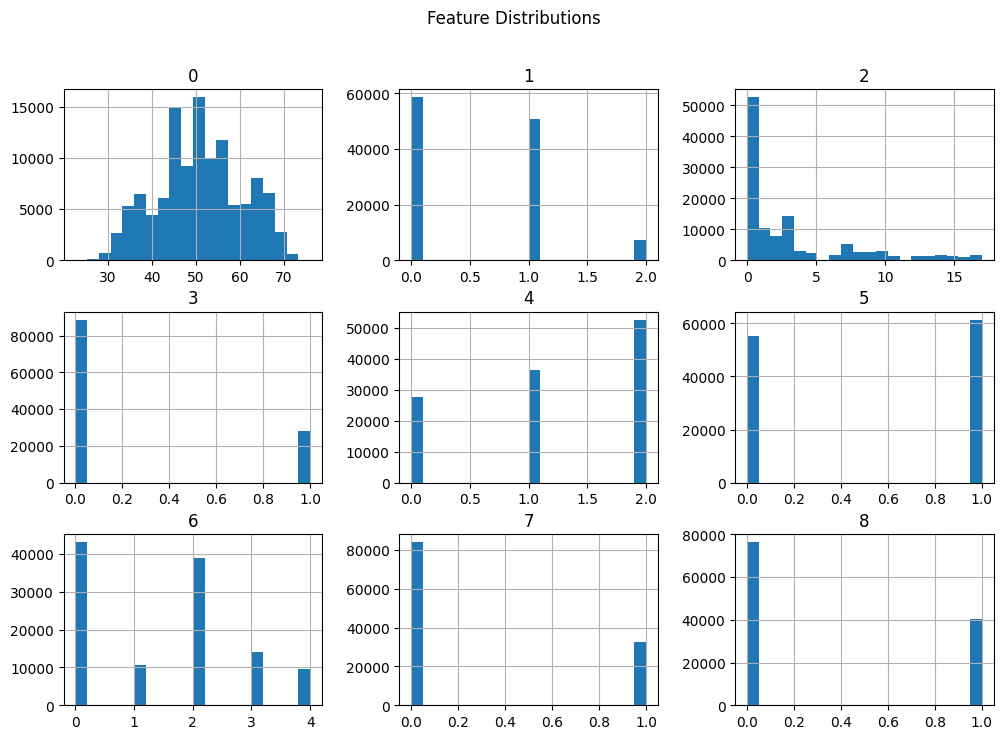

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

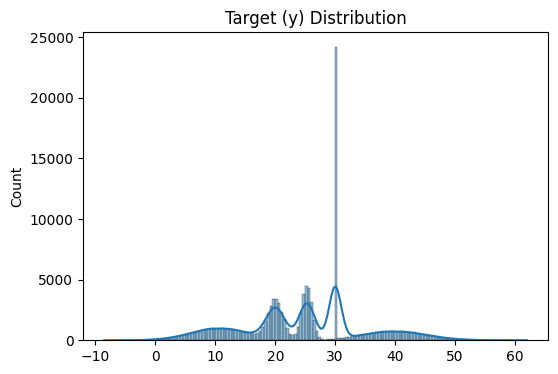

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

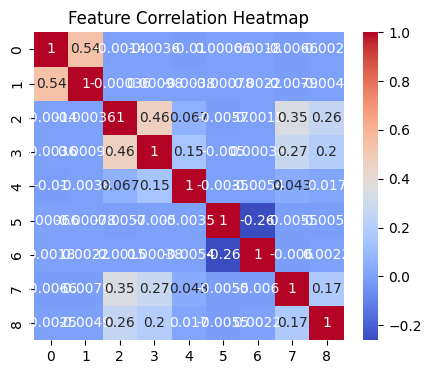

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.005597                 1.083542             1.191961   
1                  1.010288                 1.130703             1.111696   
2                  1.009502                 1.117584             1.236671   
3                  1.022519                 1.061293             1.106357   
4                  1.001058                 1.115635             1.191018   
mean               1.009793                 1.101751             1.167541   
std                0.008003                 0.028505             0.056543   

      DefaultBART_Rhat_RMSE  
0                  1.910376  
1                  1.866263  
2                  1.978569  
3                  1.812214  
4                  2.328428  
mean               1.979170  
std                0.204534  


In [10]:
rhat_df.to_csv("results/real5_BreastTumor_rhat.csv", index=False)

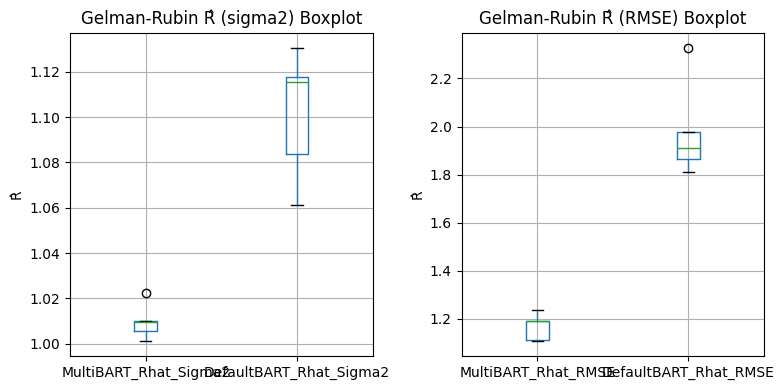

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh       bart        btz        sto          rf        xgb
0     87.529638  88.266777  88.058170  87.793977  109.458282  88.657922
1     87.349735  88.763773  88.221653  88.241693  109.713743  88.580468
2     87.999882  88.602550  88.359471  88.539629  110.045747  88.964341
3     87.850114  89.424080  88.532728  88.524832  110.812855  89.112601
4     88.770858  89.978310  89.279223  89.386394  110.663165  90.279935
5     87.867666  88.915506  88.600633  88.486396  110.808684  89.136747
6     88.010744  88.749212  88.503388  88.669498  111.041204  89.535712
7     88.229936  89.287042  88.965812  88.853022  110.612982  89.441630
8     88.598658  89.530566  88.977755  88.974872  111.407565  89.900800
9     87.556236  88.422064  88.035605  88.085489  110.821577  88.721746
mean  87.976347  88.993988  88.553444  88.555580  110.538580  89.233190
std    0.457164   0.543231   0.414081   0.456197    0.609861   0.556879



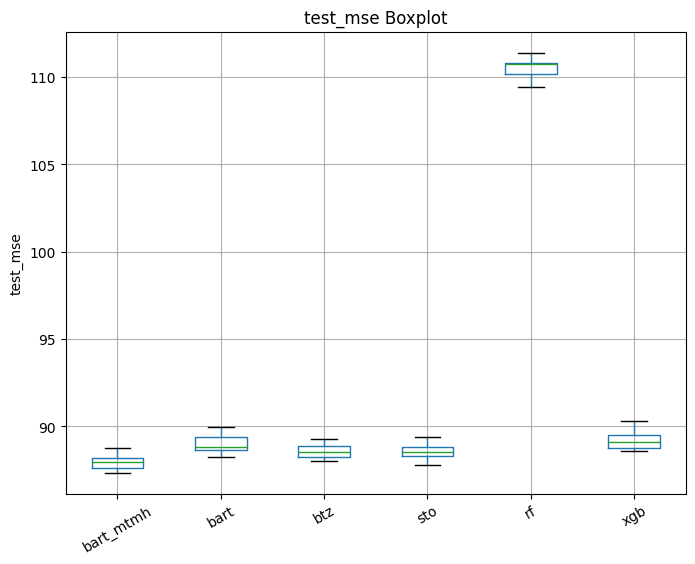

train_mse:
      bart_mtmh       bart        btz        sto         rf        xgb
0     87.494309  88.654309  88.477362  88.394237  15.534903  81.455847
1     87.441875  88.811084  88.655418  88.433301  15.447441  81.404006
2     87.349353  88.506826  88.267944  88.563377  15.395193  81.251570
3     87.239318  89.074587  88.203170  88.215254  15.370045  81.250468
4     86.919232  88.624348  88.057392  88.090259  15.341230  81.338999
5     87.217445  88.696387  88.507853  88.397586  15.404729  81.252545
6     87.161058  88.329632  88.142725  88.296210  15.432257  81.214583
7     87.018948  88.736260  88.450921  88.207895  15.364956  81.153972
8     87.072232  88.622886  87.852608  87.839629  15.369475  81.192552
9     87.336729  88.856680  88.316661  88.437539  15.472823  81.257820
mean  87.225050  88.691300  88.293205  88.287529  15.413305  81.277236
std    0.185936   0.201666   0.239845   0.209368   0.059235   0.094540



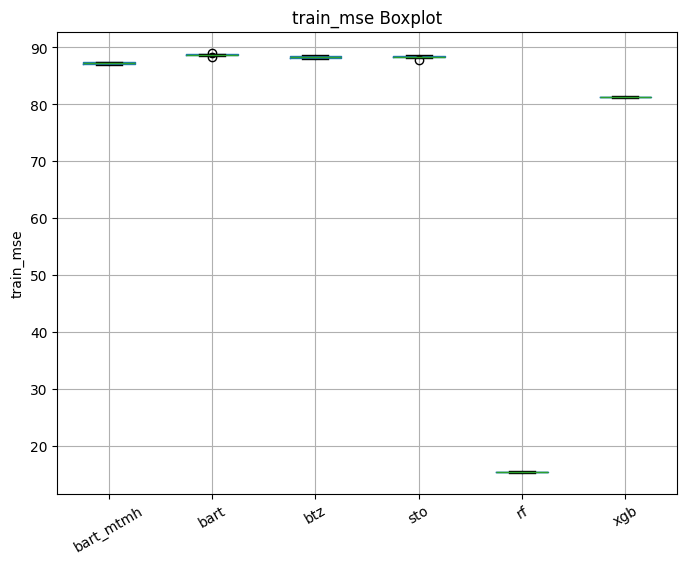

pi_length:
      bart_mtmh       bart        btz         sto
0     35.240780  35.437255  35.621046  333.047032
1     35.263667  35.480536  35.725894  334.529447
2     35.246388  35.425511  35.709391  335.035896
3     35.197123  35.505590  35.625165  336.668346
4     35.086968  35.376960  35.647788  332.522147
5     35.188082  35.444942  35.679317  335.604095
6     35.195612  35.384027  35.637067  336.167395
7     35.191305  35.495111  35.623106  332.803105
8     35.155876  35.421796  35.632640  332.823608
9     35.232639  35.484443  35.655064  335.520100
mean  35.199844  35.445617  35.655648  334.472117
std    0.051534   0.045120   0.037276    1.554013



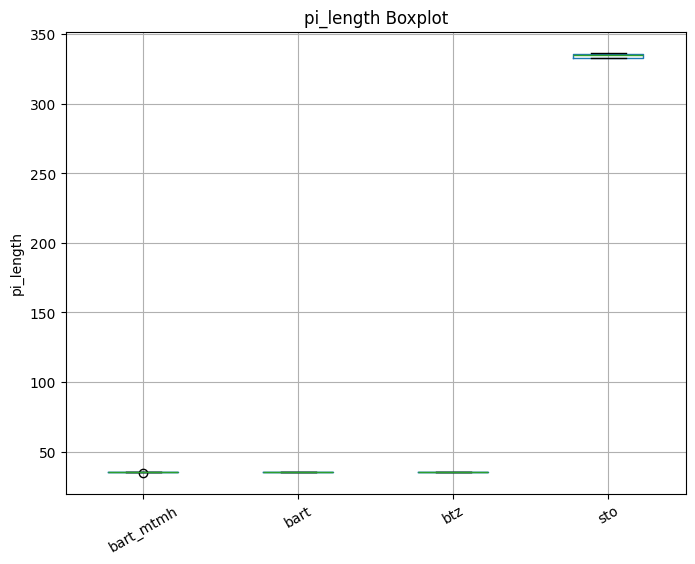

coverage:
      bart_mtmh      bart       btz  sto
0      0.921125  0.921879  0.924108  1.0
1      0.921708  0.922805  0.925137  1.0
2      0.922119  0.924074  0.923114  1.0
3      0.921708  0.922016  0.923525  1.0
4      0.919547  0.919959  0.923182  1.0
5      0.920267  0.921914  0.923251  1.0
6      0.920576  0.922085  0.922325  1.0
7      0.922291  0.920576  0.923971  1.0
8      0.919890  0.921228  0.922668  1.0
9      0.921399  0.921091  0.923045  1.0
mean   0.921063  0.921763  0.923433  1.0
std    0.000950  0.001156  0.000804  0.0



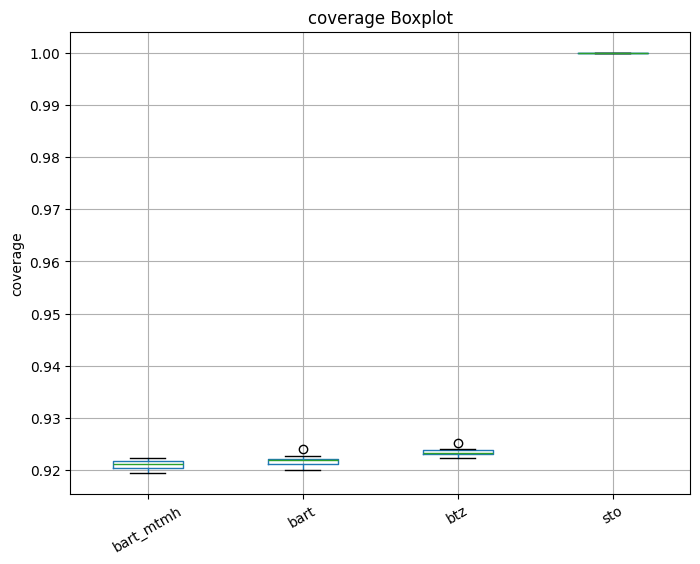

train_time:
       bart_mtmh       bart        btz        sto         rf       xgb
0     282.541621  32.603794  20.232959  98.834101  27.179497  0.488573
1     285.345957  32.163276  21.409915  97.181093  27.091286  0.614246
2     288.220624  33.608686  22.693291  94.517620  27.301086  0.521701
3     286.184163  31.888569  22.257859  95.297006  27.159102  0.440131
4     291.485201  33.049261  22.638525  94.369131  27.269607  0.414553
5     295.420691  34.007847  16.587272  96.620609  26.474348  0.175664
6     303.094126  36.682700  18.797225  93.611251  26.751873  0.213513
7     293.344575  32.556931  16.004182  97.257910  26.731799  0.178789
8     291.690632  33.500385  16.655648  96.930816  26.516593  0.197208
9     295.077212  33.908808  16.840806  94.245735  26.488014  0.202791
mean  291.240480  33.397026  19.411768  95.886527  26.896320  0.344717
std     5.986046   1.363804   2.751175   1.708385   0.337858  0.167952



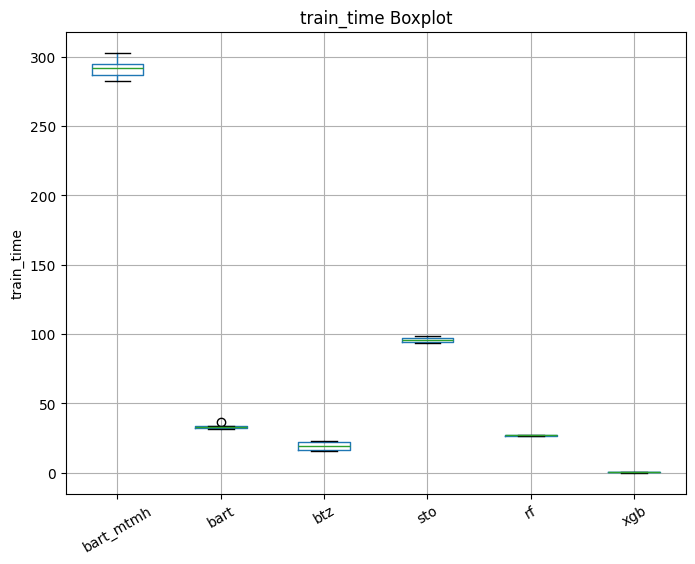

In [12]:
import matplotlib.pyplot as plt

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=100, n_post=100, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real5_BreastTumor_{k}.csv"
    v.to_csv(csv_name, index=False)